# Philadelphia Police Abuse and Assault: A Troubling Correlation


In [71]:
#I did my self assessment in R, so will be doing the data project in Python
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from shapely.geometry import Point
import numpy as np
import os




In [7]:
#load in the data
#not sure why the file path is so extensive
#JupyterHub directory acting weird

# NEVER use absolute file paths like that - use relative paths so
# notebooks and code can be distributed (i.e. through github or otherwise)

crime = pd.read_csv('../data/incidents_part1_part2.csv')
complaint = pd.read_csv('../data/ppd_complaints.csv')
demos = pd.read_csv('../data/demographics.csv')

In [8]:
#check type 
print(type(crime))
print(type(complaint))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [9]:
#data cleaning on crime data
crime['dispatch_date_time'] = pd.to_datetime(crime['dispatch_date_time']).dt.date
#we don't need this variable
crime = crime.drop(columns=['dispatch_date'])
#rename columns
crime = crime.rename(columns={'dispatch_date_time': 'date', 'dc_dist': 'dist', 'text_general_code': 'type'})
#check type convered
print(type(crime['date']))

<class 'pandas.core.series.Series'>


In [10]:
#save the month for later analysis should we want to
crime['month'] = pd.to_datetime(crime['date']).dt.strftime('%b')
#crime.head()

In [11]:
# Convert the date_received column to a datetime object
complaint['date_received'] = pd.to_datetime(complaint['date_received'])
# Rename the date_received column to date
complaint = complaint.rename(columns={'date_received': 'date'})
# Add a month column
complaint['month'] = complaint['date'].dt.strftime('%b')



# Filter the complaint data to only include 2017 complaints
complaint = complaint[complaint['date'].dt.year == 2017]

# Remove the last two digits from district_occurrence
complaint['district_occurrence'] = complaint['district_occurrence'] / 100



# Rename the columns
complaint = complaint.rename(columns={'general_cap_classification': 'type',"district_occurrence":"dist"})

# Print the number of unique districts in each DataFrame
#see if there are different amounts
print(len(crime['dist'].unique()))
print(len(complaint['dist'].unique()))

22
24


In [12]:
#check
print(type(complaint['dist']))
complaint.head()
#remove the .0 at the end of the dist value in complaint
complaint['dist'] = complaint['dist'].fillna(-1).astype(int).astype(str).str.replace('.0', '')

#see that dist is a float so let's just cast it


<class 'pandas.core.series.Series'>


/tmp/ipykernel_3529474/1481305406.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  complaint['dist'] = complaint['dist'].fillna(-1).astype(int).astype(str).str.replace('.0', '')


In [13]:
complaint['dist'] = complaint['dist'].astype(int)



#we want the districts in each data set to match
#so we will only look at the districts that are common to both sets in the analysis
complaint = complaint[complaint['dist'].isin(crime['dist'].unique())]

print(crime['dist'].unique())
print(complaint['dist'].unique())
len(complaint['dist'].unique()) == len(crime['dist'].unique())

[15 19 17  6 25 35 24 18 77 39 12  3 22  2  9 14 26 16  7  8  5  1]
[ 2 15 25 19 17 35 14  8 16  6  3 39 22 24  9 18 26 12  5  7  1 77]


True

In [14]:
# Count complaints per district
complaint_count = complaint.groupby('dist').size().reset_index(name='total_complaints')

# Count crimes
crime_count = crime['dist'].value_counts().reset_index()
crime_count.rename(columns={'index': 'dist', 'dist':'total_crime'}, inplace=True)

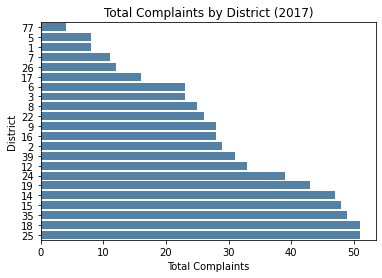

In [15]:
#graph
import seaborn as sns
import seaborn as sns

# count complaints per district 
complaint_counts = complaint.groupby('dist').size().reset_index(name='total_complaints')

# order the districts by the total number of complaints 
district_order = complaint_counts.sort_values(by='total_complaints')['dist'].tolist()

# plotting complaints by district
complaint_bar = sns.barplot(x='total_complaints', 
                            y='dist', 
                            data=complaint_counts, 
                            order=district_order, 
                            color='steelblue', 
                            orient='h')

complaint_bar.set(title='Total Complaints by District (2017)', 
                  xlabel='Total Complaints', 
                  ylabel='District')

plt.show()

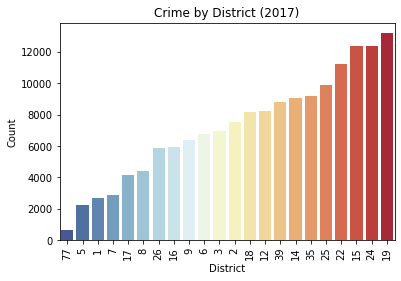

In [16]:
# sort crime count by ascending order of crimes
crime_count_sorted = crime_count.sort_values('total_crime')
crime_order = crime_count.sort_values(by='total_crime')['dist'].tolist()


# plot crimes by district heatmap
crime_plot = sns.barplot(x='dist', y='total_crime', 
                         data=crime_count_sorted,
                         order= crime_order,
                         palette='RdYlBu_r')

# set plot title and axis labels
crime_plot.set(title='Crime by District (2017)', 
               xlabel='District', 
               ylabel='Count')

# rotate x-axis labels
crime_plot.set_xticklabels(crime_count_sorted['dist'], rotation=90)

# show plot
plt.show()

In [17]:
# Merge crime_counts and complaint_counts by district
merged_counts = pd.merge(crime_count, complaint_counts, on='dist')

# calculate the correlation between complaints and crime by district
correlation = merged_counts['total_crime'].corr(merged_counts['total_complaints'])
print(correlation)


0.8238207604159442


In [18]:
#now I want to close the funnel a little bit and look particularly at whether or not 
#physical/verbal abuse is correlated to increased assaults in philly

# formatting consistent when i loook at the types of complaint and crimes
crime['type'] = crime['type'].str.lower()
complaint['type'] = complaint['type'].str.lower()

In [19]:
# complaint subset
abuse = complaint[(complaint['type'] == 'physical abuse') | (complaint['type'] == 'verbal abuse')]

# crime subset
violence = crime[(crime['type'] == 'aggravated assault no firearm') | 
                 (crime['type'] == 'other assaults') | 
                 (crime['type'] == 'aggravated assault firearm')]


In [20]:
# Aggregate data by district
abuse_totals = abuse.groupby('dist')['dist'].agg([('total', 'count')]).reset_index()
violence_totals = violence.groupby('dist')['dist'].agg([('total', 'count')]).reset_index()

# merge the two
abuseAndViolence = pd.merge(abuse_totals, violence_totals, on='dist')

In [21]:
# rename
abuseAndViolence = abuseAndViolence.rename(columns={'total_x': 'Abuse complaints', 'total_y': 'Assaults'})

In [22]:
#view it 
abuseAndViolence

,dist,Abuse complaints,Assaults
0,1,2,540
1,2,7,1294
2,3,7,1246
3,5,2,436
4,6,7,871
5,7,3,471
6,8,5,1010
7,9,8,885
8,12,8,1822
9,14,20,2219


In [79]:
corrCheck = abuseAndViolence['Abuse complaints'].corr(abuseAndViolence['Assaults'])
print(corr)

0.7747575414027139


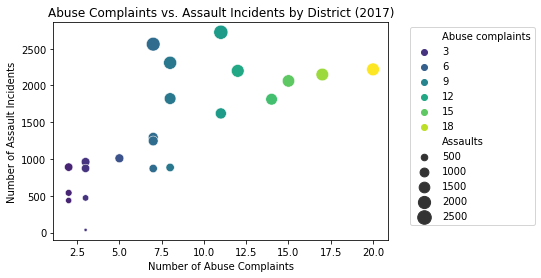

In [23]:

sns.scatterplot(x="Abuse complaints", y="Assaults", data=abuseAndViolence, size="Assaults", 
                sizes=(10, 200), palette="viridis",
              
                hue = 'Abuse complaints',
                hue_norm=(0, max(abuseAndViolence['Abuse complaints'])))

plt.xlabel("Number of Abuse Complaints")
plt.ylabel("Number of Assault Incidents")
plt.title("Abuse Complaints vs. Assault Incidents by District (2017)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [24]:
#I also want to graph based on 4 complaint quartiles to see if the relationship is clearer from that 
#perspective

# Calculating quartiles
quartiles = abuseAndViolence['Abuse complaints'].quantile(q=[0, 0.25, 0.5, 0.75, 1], interpolation='nearest')

# Assigned values as described above
abuseAndViolence['level'] = pd.cut(abuseAndViolence['Abuse complaints'], 
                                   bins=quartiles, labels=[1, 2, 3, 4], include_lowest=True)

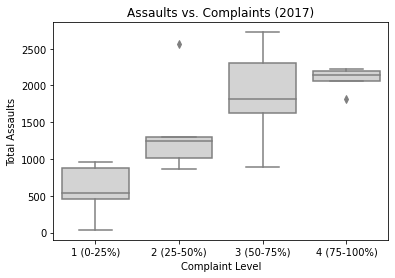

In [25]:
#plotting
labels = ['1 (0-25%)', '2 (25-50%)', '3 (50-75%)', '4 (75-100%)']

# Plot
sns.boxplot(x=abuseAndViolence['level'], y=abuseAndViolence['Assaults'], color = 'lightgrey')

#titles
plt.xlabel('Complaint Level', color = 'black')
plt.ylabel('Total Assaults', color = 'black')
plt.title('Assaults vs. Complaints (2017)',color='black')

#manually set the axis labels
plt.xticks([0, 1, 2, 3], labels, color = 'black')


plt.show()

In [78]:
#want the correlation 
corr = abuseAndViolence['level'].corr(abuseAndViolence['Assaults'])
print(corr)

0.7747575414027139


<Axes: >

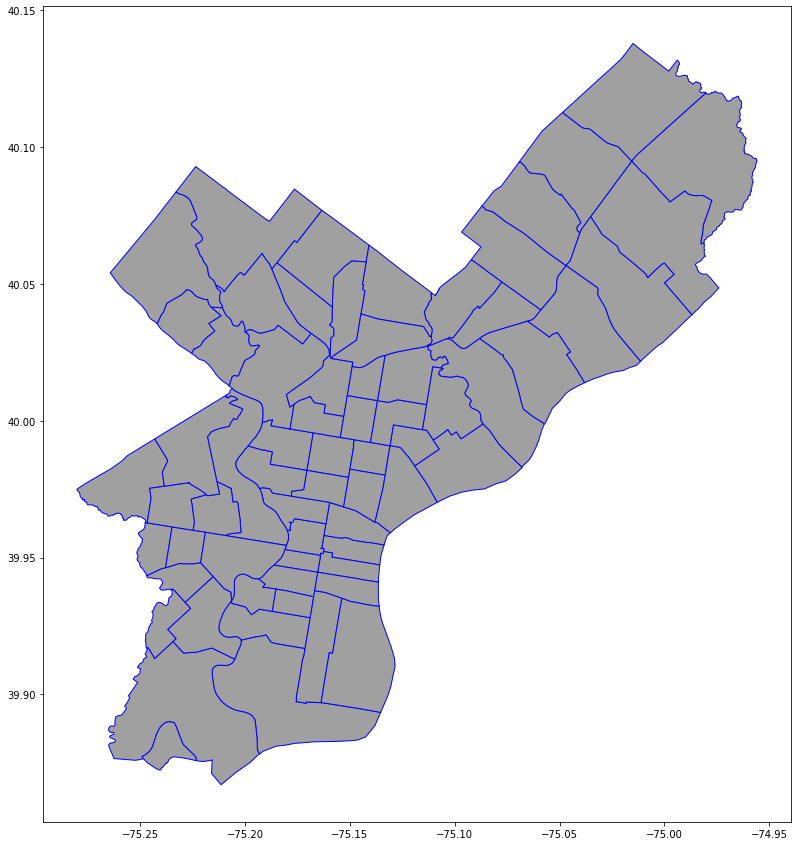

In [26]:
#now I want to finally just do some geopandas analysis
shapefile_path = "1d53400f-66f7-45b3-86fe-6aca8d7c3b5b2020329-1-lutzgd.vpipe.shp"

# Read in the shapefile
philly_districts = gpd.read_file(shapefile_path)

# View the map

philly_districts.plot(figsize=(20,15), color='#A0A0A0', edgecolor='blue')


In [27]:
#FIRST WE WILL LOOOK AT THE CRIME DISTRIBUTION OF THE DISTRICT WITH THE most and LEAST AMOUNT OF 
#complaints 

assaults = crime[(crime['dist'].isin([1,14])) & 
                 (crime['type'].isin(['aggravated assault firearm',
                                      'aggravated assault no firearm', 'other assaults']))]



In [28]:
geom = gpd.points_from_xy(assaults['point_x'],
                          assaults['point_y'])
                                   

assaults = gpd.GeoDataFrame(assaults, geometry=geom)

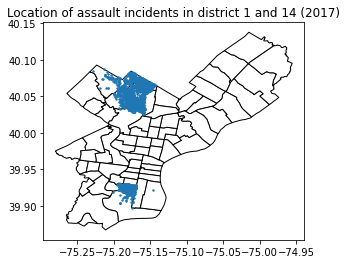

In [55]:
base = philly_districts.plot(color='white', edgecolor='black')
assaults.plot(markersize=2, ax=base,figsize = (20,12))
plt.title('Location of assault incidents in district 1 and 14 (2017)')
plt.show()

In [62]:
#now let's look at just the total crimes and not just the assaults
crimes = crime[(crime['dist'].isin([1,14]))]

geom_2 = gpd.points_from_xy(crimes['point_x'],
                          crimes['point_y'])
                                   

crimes = gpd.GeoDataFrame(crimes, geometry=geom_2)

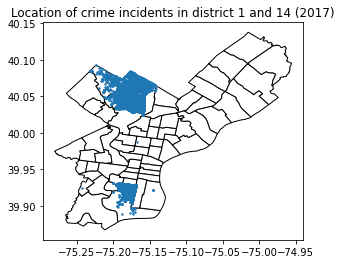

In [66]:
base = philly_districts.plot(color='white', edgecolor='black')
crimes.plot(markersize=2, ax=base)
plt.title('Location of crime incidents in district 1 and 14 (2017)')
plt.show()

we see that crimes are more dense in both districts
however, district 14 and one are not at the top and bottom of the total crime spectrum. 
district 14 is also closer to the median amount of crime than the maximum amount of crime by district
therefore there is some evidence to suggest that crime rates are not what is driving the increased amount
of assaults. In fact it truly may be due to the increase amounts of physical and verbal abuse. 

## Confounding variable analysis

It's likely that there are some other factors that are affecting the assault rates in the districts. I want to test for percentage unemployed and percentage non-white to see if these also have effects. There are factors that are very indicative of socioeconomic class, and by extension crime. If there is no relationship, then perhaps there really is no no major confounding.


In [33]:
# check if police districts are the same in both datasets
print(np.sort(crime['dist'].unique()) == np.sort(demos['police.district'].unique()))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]


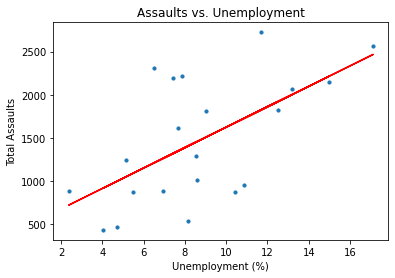

In [52]:
# fit a linear regression model and plot the line
valid_indices = np.logical_and(~np.isnan(demos['average.unemployment']), ~np.isnan(abuseAndViolence['Assaults']))

# filter the valid values
x_valid = demos['average.unemployment'][valid_indices]
y_valid = abuseAndViolence['Assaults'][valid_indices]

slope, intercept = np.polyfit(x_valid, y_valid, 1)

# plot assaults vs unemployment
fig, ax = plt.subplots()
ax.scatter(x_valid, y_valid, marker='o', s=10)
ax.set_xlabel('Unemployment (%)')
ax.set_ylabel('Total Assaults')
ax.set_title('Assaults vs. Unemployment')
plt.plot(x_valid, slope*x_valid + intercept, color='red')

plt.show()

In [53]:
#now want percent white vs. assaults. Hypothesize a downward trendline
#just going to overwrite values from graph above for ease

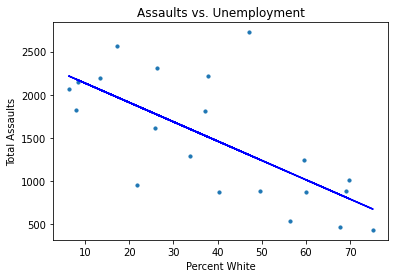

In [54]:


# fit a linear regression model and plot the line
valid_indices = np.logical_and(~np.isnan(demos['perc.non.hispanic.white']), ~np.isnan(abuseAndViolence['Assaults']))

# filter the valid values
x_valid = demos['perc.non.hispanic.white'][valid_indices]
y_valid = abuseAndViolence['Assaults'][valid_indices]

slope, intercept = np.polyfit(x_valid, y_valid, 1)

# plot assaults vs unemployment
fig, ax = plt.subplots()
ax.scatter(x_valid, y_valid, marker='o', s=10)
ax.set_xlabel('Percent White')
ax.set_ylabel('Total Assaults')
ax.set_title('Assaults vs. Unemployment')
plt.plot(x_valid, slope*x_valid + intercept, color='blue')

plt.show()